In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
from data_helper import CustomDataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
dataset = CustomDataset(root='dataset/',split='unlabeled',transform=transform)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
train = CustomDataset(root = 'dataset/', split = 'train', transform = transform)

In [8]:
import numpy as np
import torch

class BALDDropout(Strategy):
	def __init__(self, X, Y, idxs_lb, net, handler, args, n_drop=10):
		super(BALDDropout, self).__init__(X, Y, idxs_lb, net, handler, args)
		self.n_drop = n_drop

	def query(self, n):
		idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb]
		probs = self.predict_prob_dropout_split(self.X[idxs_unlabeled], self.Y[idxs_unlabeled], self.n_drop)
		pb = probs.mean(0)
		entropy1 = (-pb*torch.log(pb)).sum(1)
		entropy2 = (-probs*torch.log(probs)).sum(2).mean(0)
		U = entropy2 - entropy1
		return idxs_unlabeled[U.sort()[1][:n]]


NameError: name 'Strategy' is not defined

In [9]:
import torchvision.models as models

In [10]:
import torch.nn as nn
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
# model_ft = models.resnet18(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 800)
# input_size = 96

In [10]:
# optimizer = torch.optim.Adam(model_ft.parameters(), lr=3e-4, weight_decay=0.0008)
# criterion = torch.nn.CrossEntropyLoss()
# train_loader = DataLoader(train, batch_size=128, num_workers=0, drop_last=False, shuffle=True)

In [11]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        corrects = pred.eq(target.view(1, -1).expand_as(pred))
        correct = 0.0
        for i in corrects[0]:
            if i.item() == True:
                correct+=1
        return (correct/batch_size)*100

In [ ]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
val = CustomDataset(root = 'dataset/', split = 'val', transform = None)
val_loader = DataLoader(val, batch_size=128, num_workers=0, drop_last=False, shuffle=False)
train_loader = DataLoader(train, batch_size=128, num_workers=0, drop_last=False, shuffle=True)
feature_extract=True
model_ft_2 = models.resnet18(num_classes=800, pretrained=False)
# set_parameter_requires_grad(model_ft_2, feature_extract=True)
# num_ftrs_2 = model_ft_2.fc.in_features
# model_ft_2.fc = nn.Linear(num_ftrs_2, 800)
input_size = 96
criterion_2 = torch.nn.CrossEntropyLoss()

model_ft_2.cuda()
criterion_2.cuda()

params_to_update = model_ft_2.parameters()
print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft_2.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
# #             /print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

from tqdm import tqdm
epochs = 120
best_acc=0
epoch = 0
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(tqdm(train_loader)):
        x_batch= x_batch.cuda()
        y_batch= y_batch.cuda()
        logits = model_ft_2(x_batch)
        loss = criterion_2(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
    print("loss= ", loss)
    print(f"Epoch {epoch}\tTop1 Train accuracy {top1}")
    for counter, (x_batch, y_batch) in enumerate(tqdm(val_loader)):
        x_batch= x_batch.cuda()
        y_batch= y_batch.cuda()
        logits = model_ft_2(x_batch)
#         loss = criterion_2(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
    print(f"Epoch {epoch}\tTop1 Val accuracy {top1}")   

  0%|          | 0/200 [00:00<?, ?it/s]

Params to learn:


 37%|███▋      | 74/200 [03:48<06:15,  2.98s/it]

In [150]:
def predict_prob_dropout_split(X,n_drop):
#         loader_te = DataLoader(self.handler(X, Y, transform=self.args['transform']),
#                             shuffle=False, **self.args['loader_te_args'])

#         model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=True)
        loader_te = DataLoader(dataset, batch_size=128, num_workers=0, drop_last=False, shuffle=True)
        probs = torch.zeros([n_drop, len(X), 800])
        for i in range(n_drop):
            print('n_drop {}/{}'.format(i+1, n_drop))
            with torch.no_grad():
                idxs = 0
                for x, y in loader_te:
#                     x, y = x.to(self.device), y.to(self.device)
                    out = model_ft_2(x)
#                     print(out.shape)
                    probs[i][idxs] += F.softmax(out[1], dim=0).cpu()
                    idxs+=1
        return probs

In [151]:
def query(n):
    n_pool = 512000
    idxs_unlabeled = np.arange(n_pool)[~idxs_lb]
#     print(idxs_unlabeled.shape)
    probs = predict_prob_dropout_split(dataset, 5)
    pb = probs.mean(0)
    entropy1 = (-pb*torch.log(pb)).sum(1)
    entropy2 = (-probs*torch.log(probs)).sum(2).mean(0)
    U = entropy2 - entropy1
    return idxs_unlabeled[U.sort()[1][-n:]]

In [152]:
n_pool = 512000
idxs_lb = np.zeros(n_pool, dtype=bool)

In [153]:
X = query(12800)

n_drop 1/1


In [154]:
print(X)

[  2665   2663   2669 ... 350807 350813 350809]


In [164]:
print(type(X))
import csv
with open('bald.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for i in range(len(X)):
        writer.writerow([X[i]])

<class 'numpy.ndarray'>


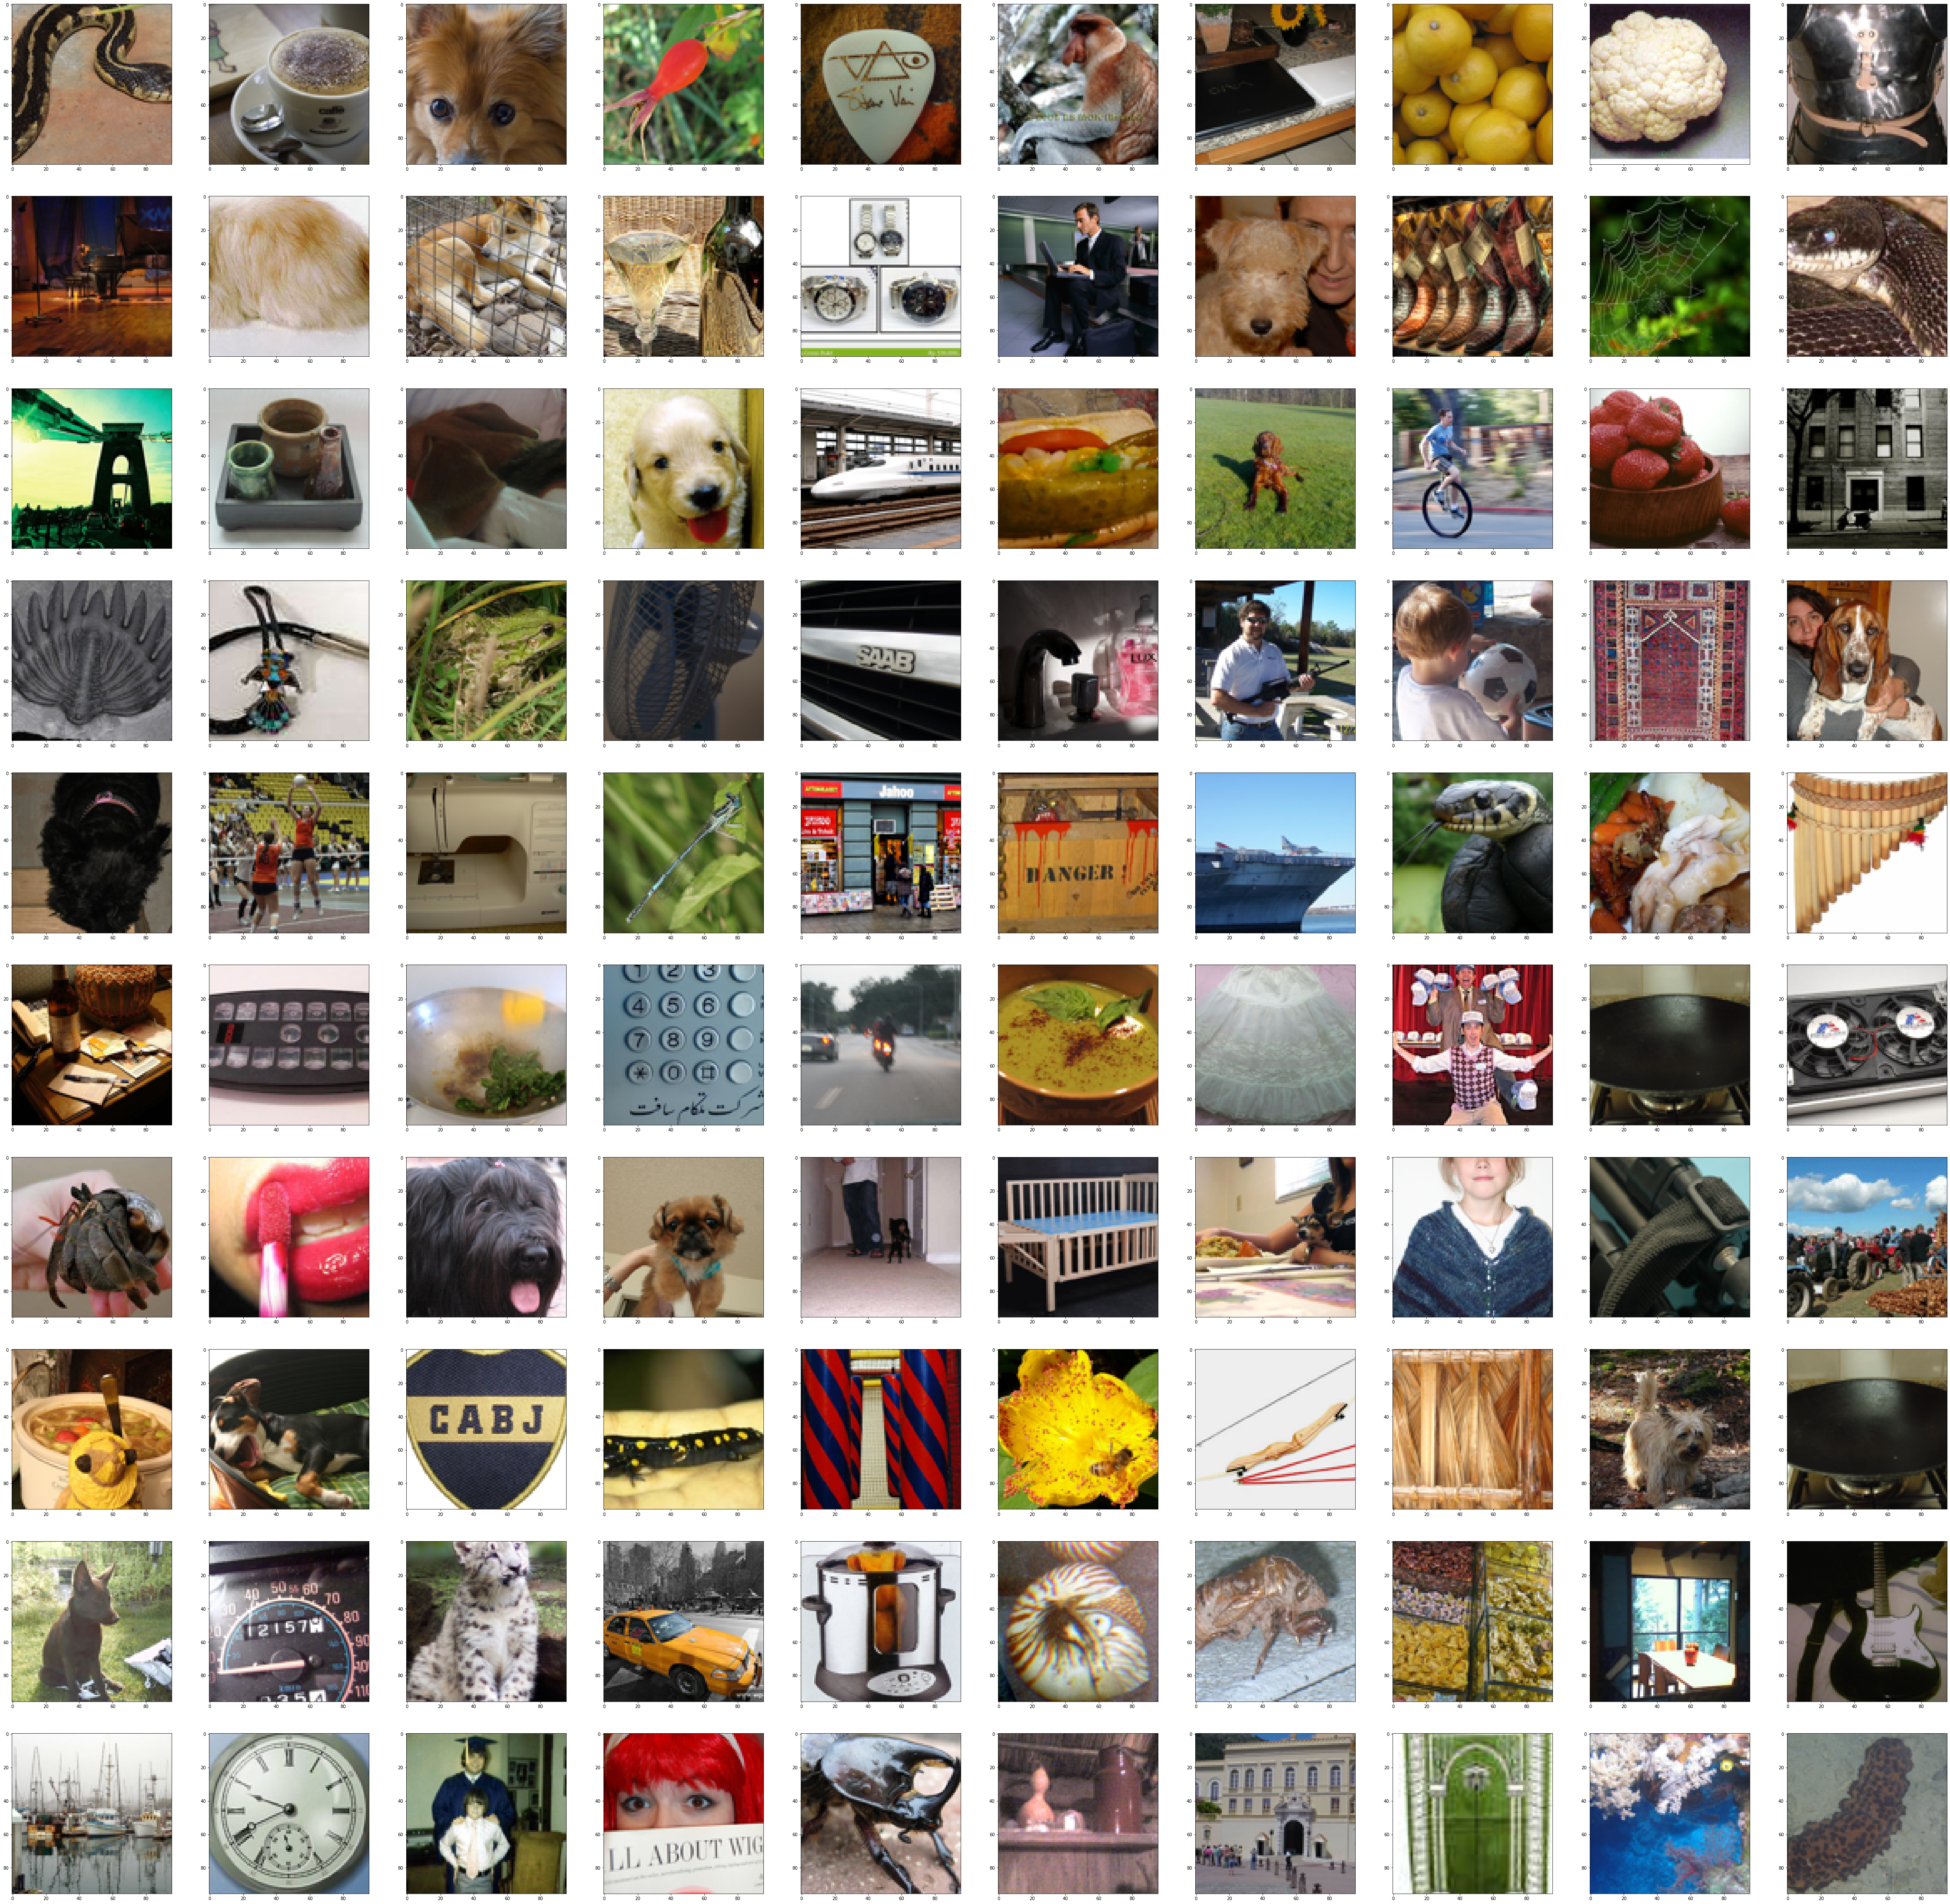

In [163]:
from PIL import Image
import matplotlib.pyplot as plt
import random 
plt.figure(figsize=(80, 80));
start = 1
for i in range(start,start+100):
    image_ind = random.randint(0, 12800)
    image_ind =X[image_ind]
    f = "./dataset/unlabeled/"+str(image_ind)+".png"
    img = Image.open(f).convert('RGB')
    plt.subplot(10, 10, i-start+1)
    plt.imshow(img)

In [170]:
Y = np.load("samples_reduced_20.npy")

In [182]:
# Z = [0]*12800

[206017 459288  11772 ... 399472 480343 268315]


In [184]:
# with open('bald.csv', mode='r') as csv_file:
#     csv_reader = csv.DictReader(csv_file)
#     line_count = 0
#     i = 0
#     for row in csv_reader:
# #         if line_count == 0:
# #             print(f'Column names are {", ".join(row)}')
# #             line_count += 1
#         print(i)
#         a = int(row['2665'])
#         Z[i] = a
#         print(Z[i])
#         line_count += 1
#         i+=1
#     print(Z)

0
2663
1
2669
2
2668
3
2667
4
2666
5
2671
6
2664
7
2673
8
2662
9
2661
10
2660
11
2659
12
2670
13
2657
14
2672
15
2681
16
2679
17
2685
18
2684
19
2683
20
2682
21
2656
22
2680
23
2674
24
2678
25
2677
26
2676
27
2675
28
2658
29
2687
30
2634
31
2632
32
2638
33
2637
34
2636
35
2635
36
2640
37
2633
38
2642
39
2631
40
2630
41
2629
42
2628
43
2639
44
2689
45
2641
46
2650
47
2648
48
2654
49
2653
50
2652
51
2651
52
2655
53
2649
54
2643
55
2647
56
2646
57
2645
58
2644
59
2686
60
2626
61
2688
62
2728
63
2726
64
2732
65
2731
66
2730
67
2729
68
2734
69
2727
70
2736
71
2725
72
2724
73
2723
74
2722
75
2733
76
2720
77
2735
78
2744
79
2742
80
2748
81
2747
82
2746
83
2745
84
2719
85
2743
86
2737
87
2741
88
2740
89
2739
90
2738
91
2721
92
2625
93
2697
94
2695
95
2701
96
2700
97
2699
98
2698
99
2703
100
2696
101
2705
102
2694
103
2693
104
2692
105
2691
106
2702
107
2690
108
2704
109
2713
110
2711
111
2717
112
2716
113
2715
114
2714
115
2718
116
2712
117
2706
118
2710
119
2709
120
2708
121
2707
122
2627
123

3247
1584
3246
1585
3220
1586
3244
1587
3238
1588
3242
1589
3241
1590
3240
1591
3239
1592
3222
1593
3126
1594
3198
1595
3196
1596
3202
1597
3201
1598
3200
1599
3199
1600
3204
1601
3197
1602
3206
1603
3195
1604
3194
1605
3193
1606
3192
1607
3203
1608
3191
1609
3205
1610
3214
1611
3212
1612
3218
1613
3217
1614
3216
1615
3215
1616
3219
1617
3213
1618
3207
1619
3211
1620
3210
1621
3209
1622
3208
1623
3128
1624
3251
1625
3041
1626
3039
1627
3045
1628
3044
1629
3043
1630
3042
1631
3047
1632
3040
1633
3049
1634
3038
1635
3037
1636
3036
1637
3035
1638
3046
1639
3033
1640
3048
1641
3057
1642
3055
1643
3061
1644
3060
1645
3059
1646
3058
1647
3032
1648
3056
1649
3050
1650
3054
1651
3053
1652
3052
1653
3051
1654
3034
1655
3063
1656
3010
1657
3008
1658
3014
1659
3013
1660
3012
1661
3011
1662
3016
1663
3009
1664
3018
1665
3007
1666
3006
1667
3005
1668
3004
1669
3015
1670
3065
1671
3017
1672
3026
1673
3024
1674
3030
1675
3029
1676
3028
1677
3027
1678
3031
1679
3025
1680
3019
1681
3023
1682
3022
1683


3083
1747
3084
1746
3085
1745
3086
1719
3087
1743
3088
1737
3089
1741
3090
1740
3091
1739
3092
1738
3093
1721
3094
1625
3095
1697
3096
1695
3097
1701
3098
1700
3099
1699
3100
1698
3101
1703
3102
1696
3103
1705
3104
1694
3105
1693
3106
1692
3107
1691
3108
1702
3109
1690
3110
1704
3111
1713
3112
1711
3113
1717
3114
1716
3115
1715
3116
1714
3117
1718
3118
1712
3119
1706
3120
1710
3121
1709
3122
1708
3123
1707
3124
1627
3125
1750
3126
1540
3127
1538
3128
1544
3129
1543
3130
1542
3131
1541
3132
1546
3133
1539
3134
1548
3135
1537
3136
1536
3137
1535
3138
1534
3139
1545
3140
1532
3141
1547
3142
1556
3143
1554
3144
1560
3145
1559
3146
1558
3147
1557
3148
1531
3149
1555
3150
1549
3151
1553
3152
1552
3153
1551
3154
1550
3155
1533
3156
1562
3157
1509
3158
1507
3159
1513
3160
1512
3161
1511
3162
1510
3163
1515
3164
1508
3165
1517
3166
1002
3167
1505
3168
1504
3169
1503
3170
1514
3171
1564
3172
1516
3173
1525
3174
1523
3175
1529
3176
1528
3177
1527
3178
1526
3179
1530
3180
1524
3181
1518
3182
1522


343092
4583
343108
4584
343204
4585
343110
4586
343132
4587
343134
4588
343128
4589
343129
4590
343130
4591
343131
4592
343126
4593
343133
4594
343125
4595
343135
4596
343136
4597
343137
4598
343138
4599
343127
4600
343139
4601
343117
4602
343119
4603
343113
4604
343114
4605
343115
4606
343116
4607
343112
4608
343118
4609
343124
4610
343120
4611
343121
4612
343122
4613
343123
4614
343201
4615
343080
4616
343203
4617
343287
4618
343289
4619
343283
4620
343284
4621
343285
4622
343286
4623
343281
4624
343288
4625
343280
4626
343290
4627
343291
4628
343292
4629
343293
4630
343282
4631
343295
4632
343272
4633
343274
4634
343268
4635
343269
4636
343270
4637
343271
4638
343297
4639
343273
4640
343279
4641
343275
4642
343276
4643
343277
4644
343278
4645
343294
4646
343266
4647
343296
4648
343318
4649
343320
4650
343314
4651
343315
4652
343316
4653
343317
4654
343312
4655
343319
4656
343311
4657
343321
4658
343322
4659
343323
4660
343324
4661
343313
4662
343264
4663
343303
4664
343305
4665
3432

342194
5541
342190
5542
342191
5543
342192
5544
342193
5545
342151
5546
342211
5547
342110
5548
342112
5549
342106
5550
342107
5551
342108
5552
342109
5553
342104
5554
342111
5555
342102
5556
342113
5557
342114
5558
342115
5559
342116
5560
342105
5561
342118
5562
342103
5563
342094
5564
342096
5565
342090
5566
342091
5567
342092
5568
342093
5569
342119
5570
342095
5571
342101
5572
342097
5573
342098
5574
342099
5575
342100
5576
342117
5577
342212
5578
342141
5579
342143
5580
342137
5581
342138
5582
342139
5583
342140
5584
342135
5585
342142
5586
342133
5587
342144
5588
342145
5589
342146
5590
342147
5591
342136
5592
342148
5593
342134
5594
342125
5595
342127
5596
342121
5597
342122
5598
342123
5599
342124
5600
342120
5601
342126
5602
342132
5603
342128
5604
342129
5605
342130
5606
342131
5607
342210
5608
342088
5609
342296
5610
342298
5611
342292
5612
342293
5613
342294
5614
342295
5615
342290
5616
342297
5617
342288
5618
342299
5619
342300
5620
342301
5621
342302
5622
342291
5623
3423

6332
344377
6333
344378
6334
344379
6335
344380
6336
344369
6337
344381
6338
344367
6339
344358
6340
344360
6341
344354
6342
344355
6343
344356
6344
344357
6345
344353
6346
344359
6347
344365
6348
344361
6349
344362
6350
344363
6351
344364
6352
344443
6353
344817
6354
344529
6355
344531
6356
344525
6357
344526
6358
344527
6359
344528
6360
344523
6361
344530
6362
344521
6363
344532
6364
344533
6365
344534
6366
344535
6367
344524
6368
344537
6369
344522
6370
344513
6371
344515
6372
344509
6373
344510
6374
344511
6375
344512
6376
344538
6377
344514
6378
344520
6379
344516
6380
344517
6381
344518
6382
344519
6383
344536
6384
344507
6385
344560
6386
344562
6387
344556
6388
344557
6389
344558
6390
344559
6391
344554
6392
344561
6393
344552
6394
344563
6395
344564
6396
344565
6397
344566
6398
344555
6399
344506
6400
344553
6401
344544
6402
344546
6403
344540
6404
344541
6405
344542
6406
344543
6407
344539
6408
344545
6409
344551
6410
344547
6411
344548
6412
344549
6413
344550
6414
344508
6415

7199
343754
7200
343745
7201
343756
7202
343757
7203
343758
7204
343759
7205
343748
7206
343760
7207
343746
7208
343737
7209
343739
7210
343733
7211
343734
7212
343735
7213
343736
7214
343732
7215
343738
7216
343744
7217
343740
7218
343741
7219
343742
7220
343743
7221
343577
7222
343823
7223
343412
7224
343414
7225
343408
7226
343409
7227
343410
7228
343411
7229
343406
7230
343413
7231
343404
7232
343415
7233
343416
7234
343417
7235
343418
7236
343407
7237
343420
7238
343405
7239
343396
7240
343398
7241
343392
7242
343393
7243
343394
7244
343395
7245
343421
7246
343397
7247
343403
7248
343399
7249
343400
7250
343401
7251
343402
7252
343419
7253
343390
7254
343443
7255
343445
7256
343439
7257
343440
7258
343441
7259
343442
7260
343437
7261
343444
7262
343435
7263
343446
7264
343447
7265
343448
7266
343449
7267
343438
7268
343389
7269
343436
7270
343427
7271
343429
7272
343423
7273
343424
7274
343425
7275
343426
7276
343422
7277
343428
7278
343434
7279
343430
7280
343431
7281
343432
7282

338650
8082
338651
8083
338647
8084
338653
8085
338659
8086
338655
8087
338656
8088
338657
8089
338658
8090
338737
8091
338615
8092
338823
8093
338825
8094
338819
8095
338820
8096
338821
8097
338822
8098
338817
8099
338824
8100
338815
8101
338826
8102
338827
8103
338828
8104
338829
8105
338818
8106
338831
8107
338816
8108
338807
8109
338809
8110
338803
8111
338804
8112
338805
8113
338806
8114
338832
8115
338808
8116
338814
8117
338810
8118
338811
8119
338812
8120
338813
8121
338830
8122
338801
8123
338854
8124
338856
8125
338850
8126
338851
8127
338852
8128
338853
8129
338848
8130
338855
8131
338846
8132
338857
8133
338858
8134
338859
8135
338860
8136
338849
8137
338800
8138
338847
8139
338838
8140
338840
8141
338834
8142
338835
8143
338836
8144
338837
8145
338833
8146
338839
8147
338845
8148
338841
8149
338842
8150
338843
8151
338844
8152
338802
8153
338614
8154
338761
8155
338763
8156
338757
8157
338758
8158
338759
8159
338760
8160
338755
8161
338762
8162
338753
8163
338764
8164
3387

8831
338904
8832
338905
8833
338906
8834
338985
8835
338864
8836
339071
8837
339073
8838
339067
8839
339068
8840
339069
8841
339070
8842
339065
8843
339072
8844
339063
8845
339074
8846
339075
8847
339076
8848
339077
8849
339066
8850
339079
8851
339064
8852
339055
8853
339057
8854
339051
8855
339052
8856
339053
8857
339054
8858
339080
8859
339056
8860
339062
8861
339058
8862
339059
8863
339060
8864
339061
8865
339078
8866
339049
8867
339102
8868
339104
8869
339098
8870
339099
8871
339100
8872
339101
8873
339096
8874
339103
8875
339094
8876
339105
8877
339106
8878
339107
8879
339108
8880
339097
8881
339048
8882
339095
8883
339086
8884
339088
8885
339082
8886
339083
8887
339084
8888
339085
8889
339081
8890
339087
8891
339093
8892
339089
8893
339090
8894
339091
8895
339092
8896
339050
8897
339109
8898
339009
8899
339011
8900
339005
8901
339006
8902
339007
8903
339008
8904
339003
8905
339010
8906
339001
8907
339012
8908
339013
8909
339014
8910
339015
8911
339004
8912
339017
8913
339002
8914

9581
338329
9582
338323
9583
338324
9584
338325
9585
338326
9586
338321
9587
338328
9588
338319
9589
338330
9590
338331
9591
338332
9592
338333
9593
338322
9594
338335
9595
338320
9596
338311
9597
338313
9598
338307
9599
338308
9600
338309
9601
338310
9602
338336
9603
338312
9604
338318
9605
338314
9606
338315
9607
338316
9608
338317
9609
338334
9610
338305
9611
338358
9612
338360
9613
338354
9614
338355
9615
338356
9616
338357
9617
338352
9618
338359
9619
338350
9620
338361
9621
338362
9622
338363
9623
338364
9624
338353
9625
338304
9626
338351
9627
338342
9628
338344
9629
338338
9630
338339
9631
338340
9632
338341
9633
338337
9634
338343
9635
338349
9636
338345
9637
338346
9638
338347
9639
338348
9640
338306
9641
338118
9642
338265
9643
338267
9644
338261
9645
338262
9646
338263
9647
338264
9648
338259
9649
338266
9650
338257
9651
338268
9652
338269
9653
338270
9654
338271
9655
338260
9656
338273
9657
338258
9658
338249
9659
338251
9660
338245
9661
338246
9662
338247
9663
338248
9664

341295
10581
341306
10582
341307
10583
341308
10584
341309
10585
341298
10586
341311
10587
341296
10588
341287
10589
341289
10590
341283
10591
341284
10592
341285
10593
341286
10594
341312
10595
341288
10596
341294
10597
341290
10598
341291
10599
341292
10600
341293
10601
341310
10602
341281
10603
341334
10604
341336
10605
341330
10606
341331
10607
341332
10608
341333
10609
341328
10610
341335
10611
341326
10612
341337
10613
341338
10614
341339
10615
341340
10616
341329
10617
341280
10618
341327
10619
341318
10620
341320
10621
341314
10622
341315
10623
341316
10624
341317
10625
341313
10626
341319
10627
341325
10628
341321
10629
341322
10630
341323
10631
341324
10632
341282
10633
341094
10634
341241
10635
341243
10636
341237
10637
341238
10638
341239
10639
341240
10640
341235
10641
341242
10642
341233
10643
341244
10644
341245
10645
341246
10646
341247
10647
341236
10648
341249
10649
341234
10650
341225
10651
341227
10652
341221
10653
341222
10654
341223
10655
341224
10656
341250
10657

11377
339605
11378
339505
11379
339507
11380
339501
11381
339502
11382
339503
11383
339504
11384
339499
11385
339506
11386
339497
11387
339508
11388
339509
11389
339510
11390
339511
11391
339500
11392
339513
11393
339498
11394
339489
11395
339491
11396
339485
11397
339486
11398
339487
11399
339488
11400
339514
11401
339490
11402
339496
11403
339492
11404
339493
11405
339494
11406
339495
11407
339512
11408
339484
11409
339536
11410
339538
11411
339532
11412
339533
11413
339534
11414
339535
11415
339530
11416
339537
11417
339528
11418
339539
11419
339540
11420
339541
11421
339542
11422
339531
11423
339543
11424
339529
11425
339520
11426
339522
11427
339516
11428
339517
11429
339518
11430
339519
11431
339515
11432
339521
11433
339527
11434
339523
11435
339524
11436
339525
11437
339526
11438
339853
11439
339360
11440
340187
11441
340189
11442
340183
11443
340184
11444
340185
11445
340186
11446
340181
11447
340188
11448
340179
11449
340190
11450
340191
11451
340192
11452
340193
11453
340182

12266
350277
12267
350278
12268
350304
12269
350280
12270
350286
12271
350282
12272
350283
12273
350284
12274
350285
12275
350302
12276
350397
12277
350326
12278
350328
12279
350322
12280
350323
12281
350324
12282
350325
12283
350320
12284
350327
12285
350318
12286
350329
12287
350330
12288
350331
12289
350332
12290
350321
12291
350333
12292
350319
12293
350310
12294
350312
12295
350306
12296
350307
12297
350308
12298
350309
12299
350305
12300
350311
12301
350317
12302
350313
12303
350314
12304
350315
12305
350316
12306
350395
12307
350769
12308
350481
12309
350483
12310
350477
12311
350478
12312
350479
12313
350480
12314
350475
12315
350482
12316
350473
12317
350484
12318
350485
12319
350486
12320
350487
12321
350476
12322
350489
12323
350474
12324
350465
12325
350467
12326
350461
12327
350462
12328
350463
12329
350464
12330
350490
12331
350466
12332
350472
12333
350468
12334
350469
12335
350470
12336
350471
12337
350488
12338
350459
12339
350512
12340
350514
12341
350508
12342
350509

In [186]:
common = np.intersect1d(Y,Z)

In [187]:
print(len(common))
print(common)

353
[   112    119    161    216    224    322    345    352    354    360
    398    409    469    488    506    529    533    552    675    727
    853    856    907    914   1055   1075   1105   1133   1157   1158
   1193   1202   1234   1313   1323   1334   1348   1368   1435   1459
   1471   1519   1590   1703   1717   1732   1762   1764   1772   1808
   1830   1888   2022   2092   2100   2148   2191   2207   2232   2342
   2353   2385   2401   2416   2470   2495   2506   2529   2576   2611
   2678   2683   2688   2753   2775   2803   2816   2823   2872   2884
   2934   2957   2979   2981   3112   3119   3148   3202   3313   3337
   3389   3425   3441   3570   3583   3609   3617   3737   3746   3784
   3787   3791   3793   3861   3886   3919   3928   3980   3987   3999
 337421 337444 337471 337496 337526 337555 337570 337599 337614 337646
 337650 337660 337680 337696 337773 337838 337840 337933 337940 337943
 337964 337992 338042 338105 338133 338223 338252 338294 338423 338443
 3